# Live Fuel Moisture Content (LFMC) Prediction with Daymet & SOLUS

**Project goal.** Predict Live Fuel Moisture Content (LFMC) by integrating meteorological variables from **Daymet** and soil attributes from **SOLUS** using reproducible, open workflows.

**Relevance.** LFMC strongly influences wildfire ignition and spread. Accurate LFMC mapping supports fire risk assessment, operational decision-making, and climate resilience planning.

**Developed by.** Ehsan Foroumandi (eforoumandi@crimson.ua.edu)


## Problem Statement

This project estimates **Live Fuel Moisture Content (LFMC)** by fusing meteorological forcings (Daymet) and soil attributes (SOLUS) and training predictive models to map LFMC in space and time. 

## How to Run (Reproducible Setup)

- This notebook is designed to run **top-to-bottom** in the I‑GUIDE Jupyter environment.
- All data should be uploaded to .data

In [1]:
# Paths & deterministic settings (no hardcoded absolute paths)
from pathlib import Path
import os
import random
import numpy as np

ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'data'

# Reproducibility
SEED = int(os.getenv("SEED", "42"))
random.seed(SEED)
np.random.seed(SEED)

## Datasets

**Daymet (daily surface weather)**  
- Variables: precipitation, minimum/maximum temperature, solar radiation, humidity, etc.  
- Used for meteorological drivers of LFMC dynamics.  
- Document preprocessing (temporal/spatial subset, resampling, feature engineering).

**SOLUS (Soil Landscapes of the United States)**  
- Variables: soil texture, depth, hydrologic group, and derived properties.  
- Used for static or slowly varying soil controls on LFMC.

## Model / Application

- **Target**: LFMC
- **Features**: Daymet variables (e.g., Tmin, Tmax, precipitation, VPD), SOLUS attributes (e.g., texture, depth, hydrologic group).
- **Train/Val/Test Split**: Strategy (spatiotemporal splits recommended).
- **Evaluation Metrics** (MAE/RMSE/R²).

## Results

Include:  
- **Performance metrics** 
- **Visualizations**

In [2]:
import sys, platform
import importlib

def check_pkg(name):
    try:
        mod = importlib.import_module(name)
        ver = getattr(mod, '__version__', 'unknown')
        print(f"{name}: {ver}")
    except Exception as e:
        print(f"{name}: not available ({e})")

print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())

Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
numpy: 2.2.6
pandas: 2.3.1
xarray: 2025.7.1
scikit-learn: not available (No module named 'scikit-learn')
matplotlib: 3.10.5
geopandas: 1.1.1
rasterio: 1.4.3
shapely: 2.1.1
requests: 2.32.4


In [3]:
# -*- coding: utf-8 -*-
"""
LFMC modeling with a single 80/20 (group-aware) train/test split.
- Robust NN + species embedding (train on 80%, evaluate on 20%).
- Static feature enrichment by lat/lon (exact + nearest-neighbor), with QC.
- Prints RMSE, r, NSE, Relative Error, MAPE **after every epoch** on TRAIN and TEST.
"""

import os
import re
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import BallTree  # for nearest-neighbor (haversine) join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

print("tensorflow :", tf.__version__)

tensorflow : 2.20.0-rc0


In [4]:


# plotting defaults
plt.rcParams.update({
    "figure.figsize": (3.5, 2.5),
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times"],
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "font.size": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
    "lines.linewidth": 1.5,
})



# -----------------------
# Reproducibility
# -----------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------
# Paths & Load
# -----------------------
CSV_PATH = "data/globe_lfmc_extracted_with_daymet.csv"  # adjust if needed
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [c.strip() for c in df.columns]

# Also load STATIC features file
STATIC_CSV_PATH = "data/SOLUS.csv"
assert os.path.exists(STATIC_CSV_PATH), f"Static CSV not found at: {STATIC_CSV_PATH}"
static_df_raw = pd.read_csv(STATIC_CSV_PATH, low_memory=False)
static_df_raw.columns = [c.strip() for c in static_df_raw.columns]



In [5]:
# -----------------------
# Preprocessing
# -----------------------
def norm(s): return re.sub(r"[^a-z0-9]+", "", str(s).lower())
def match_col(name_guess, cols):
    tn = norm(name_guess)
    for c in cols:
        if norm(c) == tn:
            return c
    return None

def detect_lat_lon_cols(cols):
    lat_candidates, lon_candidates = [], []
    for c in cols:
        cn = norm(c)
        if "lat" in cn: lat_candidates.append(c)
        if ("lon" in cn) or ("lng" in cn) or (("long" in cn) and ("length" not in cn)):
            lon_candidates.append(c)
    def pick(cands):
        if not cands: return None
        return sorted(cands, key=lambda x: (len(norm(x)), x))[0]
    return pick(lat_candidates), pick(lon_candidates)

TARGET_COL_GUESS  = "LFMC value (%)"
SPECIES_COL_GUESS = "Species collected"
LAT_COL_GUESS     = "Latitude (WGS84, EPSG:4326)"
LON_COL_GUESS     = "Longitude (WGS84, EPSG:4326)"
DATE_COL_GUESS    = "Sampling date (YYYYMMDD)"

TARGET_COL  = match_col(TARGET_COL_GUESS, df.columns)  or TARGET_COL_GUESS
SPECIES_COL = match_col(SPECIES_COL_GUESS, df.columns) or SPECIES_COL_GUESS
LAT_COL     = match_col(LAT_COL_GUESS, df.columns)     or LAT_COL_GUESS
LON_COL     = match_col(LON_COL_GUESS, df.columns)     or LON_COL_GUESS
DATE_COL    = match_col(DATE_COL_GUESS, df.columns)    or DATE_COL_GUESS

assert TARGET_COL in df.columns, f"Target '{TARGET_COL_GUESS}' not found."
assert LAT_COL in df.columns and LON_COL in df.columns, "Main CSV must contain latitude/longitude columns."

# -----------------------
# Basic cleaning: remove absurd targets
# -----------------------
df = df[df[TARGET_COL] <= 1000].reset_index(drop=True)

# -----------------------
# Date handling (no seasonal features)
# -----------------------
if DATE_COL in df.columns:
    df["_date"] = pd.to_datetime(df[DATE_COL].astype(str), errors="coerce")
    df["_year"] = df["_date"].dt.year
else:
    df["_date"] = pd.NaT
    df["_year"] = np.nan

# =============================================================================
# Static feature enrichment (by lat/lon)
# =============================================================================
EXACT_DECIMALS = 4          
NEAREST_JOIN_MAX_KM = 5.0  
EARTH_RADIUS_KM = 6371.0088

# Detect lat/lon in the static file
stat_lat_col, stat_lon_col = detect_lat_lon_cols(static_df_raw.columns)
assert stat_lat_col is not None and stat_lon_col is not None, \
    f"Could not detect lat/lon columns in static CSV. Found: lat={stat_lat_col}, lon={stat_lon_col}"

# Ensure numeric lat/lon
static_df = static_df_raw.copy()
static_df[stat_lat_col] = pd.to_numeric(static_df[stat_lat_col], errors="coerce")
static_df[stat_lon_col] = pd.to_numeric(static_df[stat_lon_col], errors="coerce")
static_df = static_df.dropna(subset=[stat_lat_col, stat_lon_col]).reset_index(drop=True)

# Prepare static feature columns (exclude coordinates)
static_feature_cols = [c for c in static_df.columns if c not in [stat_lat_col, stat_lon_col]]

# 1) Exact-merge on rounded lat/lon
df["_lat_r"] = pd.to_numeric(df[LAT_COL], errors="coerce").round(EXACT_DECIMALS)
df["_lon_r"] = pd.to_numeric(df[LON_COL], errors="coerce").round(EXACT_DECIMALS)

static_df["_lat_r"] = static_df[stat_lat_col].round(EXACT_DECIMALS)
static_df["_lon_r"] = static_df[stat_lon_col].round(EXACT_DECIMALS)

if len(static_df) > 0:
    num_cols = [c for c in static_feature_cols if pd.api.types.is_numeric_dtype(static_df[c])]
    agg_dict = {c: "mean" for c in num_cols}
    static_grouped = static_df.groupby(["_lat_r", "_lon_r"], as_index=False).agg(agg_dict) if agg_dict else \
        static_df.drop_duplicates(["_lat_r", "_lon_r"])
else:
    static_grouped = static_df

# Prefix to avoid collisions
prefixed_cols_map = {c: f"static_{c}" for c in static_grouped.columns if c not in ["_lat_r", "_lon_r"]}
static_grouped = static_grouped.rename(columns=prefixed_cols_map)

# Merge exact matches
df = df.merge(static_grouped, how="left", on=["_lat_r", "_lon_r"])
static_prefixed_cols = [c for c in df.columns if c.startswith("static_")]
exact_matched_mask = df[static_prefixed_cols].notna().any(axis=1) if static_prefixed_cols else pd.Series([False]*len(df))

print(f"[Static join] Exact-merge precision: {EXACT_DECIMALS} decimals.")
print(f"[Static join] Exact matches: {int(exact_matched_mask.sum()):,} / {len(df):,}")

# 2) Nearest-neighbor fallback
if static_df.shape[0] > 0 and (~exact_matched_mask).any():
    static_coords_rad = np.deg2rad(static_df[[stat_lat_col, stat_lon_col]].values.astype(float))
    tree = BallTree(static_coords_rad, metric="haversine")

    need_idx = np.where(~exact_matched_mask.values)[0]
    main_coords_rad = np.deg2rad(df.loc[need_idx, [LAT_COL, LON_COL]].values.astype(float))
    dists_rad, nn_idx = tree.query(main_coords_rad, k=1)
    dists_km = (dists_rad.ravel() * EARTH_RADIUS_KM)
    within = dists_km <= NEAREST_JOIN_MAX_KM

    filled = 0
    if static_feature_cols:
        take_rows = nn_idx.ravel()[within]
        source_rows = static_df.iloc[take_rows, :]

        fill_df = pd.DataFrame(index=df.index, columns=[f"static_{c}" for c in static_feature_cols], dtype=float)
        for c in static_feature_cols:
            fill_df.loc[need_idx[within], f"static_{c}"] = pd.to_numeric(source_rows[c].values, errors="coerce")

        for c in [f"static_{x}" for x in static_feature_cols]:
            if c not in df.columns:
                df[c] = np.nan
            mask_targets = df[c].isna() & fill_df[c].notna()
            df.loc[mask_targets, c] = fill_df.loc[mask_targets, c]
            filled += int(mask_targets.sum())

    print(f"[Static join] Nearest-neighbor fallback within {NEAREST_JOIN_MAX_KM} km filled values in {filled:,} cells "
          f"across {int(within.sum()):,} rows.")

# Clean up helper columns
df.drop(columns=["_lat_r", "_lon_r"], inplace=True, errors="ignore")

# =============================================================================
# STATIC QC: drop any row where at least one static feature < –100
# =============================================================================
static_cols_present = [c for c in df.columns if c.startswith("static_")]
if static_cols_present:
    for c in static_cols_present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    bad_mask = (df[static_cols_present] < -100).any(axis=1)
    n_bad = int(bad_mask.sum())
    if n_bad > 0:
        df = df.loc[~bad_mask].reset_index(drop=True)
    print(f"[Static QC] Dropped {n_bad:,} rows with any static feature < –100 "
          f"(remaining: {len(df):,}).")
else:
    print("[Static QC] No static_* columns present; no QC row drops applied.")

# -----------------------
# Build target
# -----------------------
y_all = df[TARGET_COL].astype(np.float32).values

# -----------------------
# Candidate input columns
# -----------------------
EXCLUDE_INPUTS = {
    DATE_COL, "_date",
    "daymet_start", "daymet_end",
    TARGET_COL,
}
# exclude explicit lat/lon *as features* to reduce leakage
EXCLUDE_INPUTS.update([LAT_COL, LON_COL])

# Ensure species column exists
if SPECIES_COL not in df.columns:
    df[SPECIES_COL] = "__UNK__"

# Keep every column except excluded ones
keep_cols = [c for c in df.columns if c not in EXCLUDE_INPUTS]

# Separate species vs numeric
if SPECIES_COL in keep_cols:
    keep_cols.remove(SPECIES_COL)

# Coerce non-species to numeric where possible
X_num_df = pd.DataFrame(index=df.index)
for c in keep_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        X_num_df[c] = df[c]
    else:
        X_num_df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop columns that are entirely NaN after coercion
X_num_df = X_num_df.dropna(axis=1, how="all")

# Report how many static features made it into numeric set
n_static_in_model = sum(1 for c in X_num_df.columns if c.startswith("static_"))
print(f"[Static join] Static numeric features available for modeling: {n_static_in_model}")

# -----------------------
# Species ids
# -----------------------
species_raw = df[SPECIES_COL].astype("string").fillna("__UNK__")
species_cats = pd.Index(sorted(species_raw.unique()))
species_to_id = {sp: (i+1) for i, sp in enumerate(species_cats)}  # reserve 0 for unknown
UNKNOWN_ID = 0
sp_ids_all = species_raw.map(lambda s: species_to_id.get(s, UNKNOWN_ID)).astype("int32").values
num_species = int(len(species_cats))
print(f"Species known: {num_species} (+1 for unknown id={UNKNOWN_ID})")

# -----------------------
# Grouping for a single 80/20 split (coarse lat/lon + year)
# -----------------------
def has_col(col): return col in df.columns and df[col].notna().any()

if has_col(LAT_COL) and has_col(LON_COL):
    lat_blk = df[LAT_COL].round(2).astype(str)
    lon_blk = df[LON_COL].round(2).astype(str)
else:
    lat_blk = pd.Series(["_noloc_"]*len(df))
    lon_blk = pd.Series(["_noloc_"]*len(df))

if df["_year"].notna().any():
    year_str = df["_year"].fillna(-1).astype(int).astype(str)
else:
    year_str = pd.Series(["_noyear_"]*len(df))

groups_all = (lat_blk + "_" + lon_blk + "_" + year_str).values

# -----------------------
# Train/test split by groups
# -----------------------
TEST_SIZE = 0.20
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
train_idx, test_idx = next(gss.split(X_num_df, y_all, groups=groups_all))

Xnum_train_df = X_num_df.iloc[train_idx].reset_index(drop=True)
Xnum_test_df  = X_num_df.iloc[test_idx].reset_index(drop=True)
y_train       = y_all[train_idx]
y_test        = y_all[test_idx]
sp_train_ids  = sp_ids_all[train_idx]
sp_test_ids   = sp_ids_all[test_idx]

print(f"Train samples: {len(Xnum_train_df):,} | Test samples: {len(Xnum_test_df):,} | Features: {Xnum_train_df.shape[1]}")

# -----------------------
# Impute & scale numeric inputs (fit on TRAIN, apply to TEST)
# -----------------------
model_cols = list(Xnum_train_df.columns)
imp_final = SimpleImputer(strategy="median")
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_num_imputed = imp_final.fit_transform(Xnum_train_df[model_cols])
X_test_num_imputed  = imp_final.transform(Xnum_test_df[model_cols])
X_train_num_std = scaler.fit_transform(X_train_num_imputed)
X_test_num_std  = scaler.transform(X_test_num_imputed)
n_num = X_train_num_std.shape[1]
print(f"Numeric feature dimension: {n_num}")

# -----------------------
# Sample weights for species imbalance (computed from TRAIN only)
# -----------------------
counts = np.bincount(sp_train_ids, minlength=num_species+1)
weights_by_id = 1.0 / np.maximum(counts, 1)
sample_weight_train = weights_by_id[sp_train_ids]

# -----------------------
# Metrics helpers
# -----------------------
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r = float(np.corrcoef(y_true, y_pred)[0, 1]) if len(y_true) >= 2 else np.nan
    var = float(np.var(y_true))
    nse = float(1.0 - np.sum((y_true - y_pred)**2) / (len(y_true) * var)) if var > 0 else np.nan
    relative_error = np.mean(np.abs(y_pred - y_true) / np.where(y_true != 0, np.abs(y_true), np.nan))
    mape = np.nanmean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, np.nan))) * 100
    return {"rmse": rmse, "r": r, "nse": nse, "relative_error": relative_error, "mape": mape}



[Static join] Exact-merge precision: 4 decimals.
[Static join] Exact matches: 89,823 / 89,995
[Static join] Nearest-neighbor fallback within 5.0 km filled values in 0 cells across 0 rows.
[Static QC] Dropped 64,757 rows with any static feature < –100 (remaining: 25,238).
[Static join] Static numeric features available for modeling: 128
Species known: 121 (+1 for unknown id=0)
Train samples: 20,781 | Test samples: 4,457 | Features: 151
Numeric feature dimension: 151


In [6]:
# -----------------------
# Build Keras model
# Predicts standardized y
# -----------------------
def build_model(n_num, n_species, emb_dim=None, l2=1e-4, lr=3e-4, dropout1=0.2, dropout2=0.2, dropout3=0.1):
    if emb_dim is None:
        emb_dim = min(32, max(2, int(np.ceil(np.log2(max(n_species, 2))) + 1)))
    reg = keras.regularizers.l2(l2)

    num_in = keras.Input(shape=(n_num,), dtype="float32", name="num")
    sp_in  = keras.Input(shape=(), dtype="int32",   name="species_id")

    emb = layers.Embedding(input_dim=n_species + 1, output_dim=emb_dim, name="species_emb")(sp_in)  # +1 unknown
    emb = layers.Flatten(name="species_emb_flat")(emb)

    x = layers.Concatenate(name="concat")([num_in, emb])
    x = layers.Dense(512, activation="relu", kernel_regularizer=reg, name="dense0")(x)
    x = layers.BatchNormalization(name="bn0")(x)
    x = layers.Dropout(dropout1, name="drop0")(x)

    x = layers.Dense(256, activation="relu", kernel_regularizer=reg, name="dense1")(x)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.Dropout(dropout1, name="drop1")(x)

    x = layers.Dense(128, activation="relu", kernel_regularizer=reg, name="dense2")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.Dropout(dropout2, name="drop2")(x)

    x = layers.Dense(64, activation="relu", kernel_regularizer=reg, name="dense3")(x)
    x = layers.BatchNormalization(name="bn3")(x)
    x = layers.Dropout(dropout3, name="drop3")(x)

    out = layers.Dense(1, activation="linear", name="lfmc")(x)

    model = keras.Model(inputs=[num_in, sp_in], outputs=out, name="lfmc_dnn_emb")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(delta=10.0),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

# -----------------------
# Callback to print metrics after each epoch (TRAIN + TEST)
# -----------------------
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, Xtr, sp_tr, y_tr, Xte, sp_te, y_te, y_scaler, every=1):
        super().__init__()
        self.Xtr, self.sp_tr, self.y_tr = Xtr, sp_tr, y_tr
        self.Xte, self.sp_te, self.y_te = Xte, sp_te, y_te
        self.yscaler = y_scaler
        self.every = max(1, int(every))

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0:
            return
        # TRAIN preds
        yhat_tr_s = self.model.predict([self.Xtr, self.sp_tr], verbose=0).ravel()
        yhat_tr = self.yscaler.inverse_transform(yhat_tr_s.reshape(-1,1)).ravel()
        m_tr = compute_metrics(self.y_tr, yhat_tr)

        # TEST preds
        yhat_te_s = self.model.predict([self.Xte, self.sp_te], verbose=0).ravel()
        yhat_te = self.yscaler.inverse_transform(yhat_te_s.reshape(-1,1)).ravel()
        m_te = compute_metrics(self.y_te, yhat_te)

        # Print nicely
        print(f"[Epoch {epoch+1:03d}] "
              f"TRAIN RMSE={m_tr['rmse']:.3f} R={m_tr['r']:.3f} NSE={m_tr['nse']:.3f} "
              f"RE={m_tr['relative_error']:.3f} MAPE={m_tr['mape']:.3f} | "
              f"TEST RMSE={m_te['rmse']:.3f} R={m_te['r']:.3f} NSE={m_te['nse']:.3f} "
              f"RE={m_te['relative_error']:.3f} MAPE={m_te['mape']:.3f}")

        # Optionally log into Keras history
        if logs is not None:
            logs.update({
                "rmse_train": m_tr["rmse"], "r_train": m_tr["r"], "nse_train": m_tr["nse"],
                "re_train": m_tr["relative_error"], "mape_train": m_tr["mape"],
                "rmse_test": m_te["rmse"], "r_test": m_te["r"], "nse_test": m_te["nse"],
                "re_test": m_te["relative_error"], "mape_test": m_te["mape"],
            })



In [7]:
# -*- coding: utf-8 -*-
"""
LFMC modeling with a single 80/20 (group-aware) train/test split.
- No cross-validation.
- Robust NN + species embedding (train on 80%, evaluate on 20%).
- Static feature enrichment by lat/lon (exact + nearest-neighbor), with QC.
- **NEW:** Prints RMSE, r, NSE, Relative Error, MAPE **after every epoch** on TRAIN and TEST.
"""

import os
import re
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import BallTree  # for nearest-neighbor (haversine) join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

print("tensorflow :", tf.__version__)



# ---------- Publication-quality plotting defaults ----------
plt.rcParams.update({
    "figure.figsize": (3.5, 2.5),       # Nature single-column width ≈ 88 mm
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times"],
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "font.size": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
    "lines.linewidth": 1.5,
})



# -----------------------
# Reproducibility
# -----------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------
# Paths & Load
# -----------------------
CSV_PATH = "globe_lfmc_extracted_with_daymet.csv"  # adjust if needed
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [c.strip() for c in df.columns]

# Also load STATIC features file (provided by user)
STATIC_CSV_PATH = "SOLUS.csv"  # uploaded path
assert os.path.exists(STATIC_CSV_PATH), f"Static CSV not found at: {STATIC_CSV_PATH}"
static_df_raw = pd.read_csv(STATIC_CSV_PATH, low_memory=False)
static_df_raw.columns = [c.strip() for c in static_df_raw.columns]

# -----------------------
# Column names (robust to minor header diffs)
# -----------------------
def norm(s): return re.sub(r"[^a-z0-9]+", "", str(s).lower())
def match_col(name_guess, cols):
    tn = norm(name_guess)
    for c in cols:
        if norm(c) == tn:
            return c
    return None

def detect_lat_lon_cols(cols):
    """Heuristically detect latitude and longitude columns from a set of column names."""
    lat_candidates, lon_candidates = [], []
    for c in cols:
        cn = norm(c)
        if "lat" in cn: lat_candidates.append(c)
        if ("lon" in cn) or ("lng" in cn) or (("long" in cn) and ("length" not in cn)):
            lon_candidates.append(c)
    def pick(cands):
        if not cands: return None
        return sorted(cands, key=lambda x: (len(norm(x)), x))[0]
    return pick(lat_candidates), pick(lon_candidates)

TARGET_COL_GUESS  = "LFMC value (%)"
SPECIES_COL_GUESS = "Species collected"
LAT_COL_GUESS     = "Latitude (WGS84, EPSG:4326)"
LON_COL_GUESS     = "Longitude (WGS84, EPSG:4326)"
DATE_COL_GUESS    = "Sampling date (YYYYMMDD)"

TARGET_COL  = match_col(TARGET_COL_GUESS, df.columns)  or TARGET_COL_GUESS
SPECIES_COL = match_col(SPECIES_COL_GUESS, df.columns) or SPECIES_COL_GUESS
LAT_COL     = match_col(LAT_COL_GUESS, df.columns)     or LAT_COL_GUESS
LON_COL     = match_col(LON_COL_GUESS, df.columns)     or LON_COL_GUESS
DATE_COL    = match_col(DATE_COL_GUESS, df.columns)    or DATE_COL_GUESS

assert TARGET_COL in df.columns, f"Target '{TARGET_COL_GUESS}' not found."
assert LAT_COL in df.columns and LON_COL in df.columns, "Main CSV must contain latitude/longitude columns."

# -----------------------
# Basic cleaning: remove absurd targets
# -----------------------
df = df[df[TARGET_COL] <= 1000].reset_index(drop=True)

# -----------------------
# Date handling (no seasonal features)
# -----------------------
if DATE_COL in df.columns:
    df["_date"] = pd.to_datetime(df[DATE_COL].astype(str), errors="coerce")
    df["_year"] = df["_date"].dt.year
else:
    df["_date"] = pd.NaT
    df["_year"] = np.nan

# =============================================================================
# Static feature enrichment (by lat/lon)
# =============================================================================
EXACT_DECIMALS = 4           # exact-match precision on lat/lon (degrees)
NEAREST_JOIN_MAX_KM = 5.0    # max distance for nearest-neighbor fallback (km)
EARTH_RADIUS_KM = 6371.0088

# Detect lat/lon in the static file
stat_lat_col, stat_lon_col = detect_lat_lon_cols(static_df_raw.columns)
assert stat_lat_col is not None and stat_lon_col is not None, \
    f"Could not detect lat/lon columns in static CSV. Found: lat={stat_lat_col}, lon={stat_lon_col}"

# Ensure numeric lat/lon
static_df = static_df_raw.copy()
static_df[stat_lat_col] = pd.to_numeric(static_df[stat_lat_col], errors="coerce")
static_df[stat_lon_col] = pd.to_numeric(static_df[stat_lon_col], errors="coerce")
static_df = static_df.dropna(subset=[stat_lat_col, stat_lon_col]).reset_index(drop=True)

# Prepare static feature columns (exclude coordinates)
static_feature_cols = [c for c in static_df.columns if c not in [stat_lat_col, stat_lon_col]]

# 1) Exact-merge on rounded lat/lon
df["_lat_r"] = pd.to_numeric(df[LAT_COL], errors="coerce").round(EXACT_DECIMALS)
df["_lon_r"] = pd.to_numeric(df[LON_COL], errors="coerce").round(EXACT_DECIMALS)

static_df["_lat_r"] = static_df[stat_lat_col].round(EXACT_DECIMALS)
static_df["_lon_r"] = static_df[stat_lon_col].round(EXACT_DECIMALS)

# If multiple static rows share same rounded lat/lon, average numeric columns
if len(static_df) > 0:
    num_cols = [c for c in static_feature_cols if pd.api.types.is_numeric_dtype(static_df[c])]
    agg_dict = {c: "mean" for c in num_cols}
    static_grouped = static_df.groupby(["_lat_r", "_lon_r"], as_index=False).agg(agg_dict) if agg_dict else \
        static_df.drop_duplicates(["_lat_r", "_lon_r"])
else:
    static_grouped = static_df

# Prefix to avoid collisions
prefixed_cols_map = {c: f"static_{c}" for c in static_grouped.columns if c not in ["_lat_r", "_lon_r"]}
static_grouped = static_grouped.rename(columns=prefixed_cols_map)

# Merge exact matches
df = df.merge(static_grouped, how="left", on=["_lat_r", "_lon_r"])
static_prefixed_cols = [c for c in df.columns if c.startswith("static_")]
exact_matched_mask = df[static_prefixed_cols].notna().any(axis=1) if static_prefixed_cols else pd.Series([False]*len(df))

print(f"[Static join] Exact-merge precision: {EXACT_DECIMALS} decimals.")
print(f"[Static join] Exact matches: {int(exact_matched_mask.sum()):,} / {len(df):,}")

# 2) Nearest-neighbor fallback
if static_df.shape[0] > 0 and (~exact_matched_mask).any():
    static_coords_rad = np.deg2rad(static_df[[stat_lat_col, stat_lon_col]].values.astype(float))
    tree = BallTree(static_coords_rad, metric="haversine")

    need_idx = np.where(~exact_matched_mask.values)[0]
    main_coords_rad = np.deg2rad(df.loc[need_idx, [LAT_COL, LON_COL]].values.astype(float))
    dists_rad, nn_idx = tree.query(main_coords_rad, k=1)
    dists_km = (dists_rad.ravel() * EARTH_RADIUS_KM)
    within = dists_km <= NEAREST_JOIN_MAX_KM

    filled = 0
    if static_feature_cols:
        take_rows = nn_idx.ravel()[within]
        source_rows = static_df.iloc[take_rows, :]

        fill_df = pd.DataFrame(index=df.index, columns=[f"static_{c}" for c in static_feature_cols], dtype=float)
        for c in static_feature_cols:
            fill_df.loc[need_idx[within], f"static_{c}"] = pd.to_numeric(source_rows[c].values, errors="coerce")

        for c in [f"static_{x}" for x in static_feature_cols]:
            if c not in df.columns:
                df[c] = np.nan
            mask_targets = df[c].isna() & fill_df[c].notna()
            df.loc[mask_targets, c] = fill_df.loc[mask_targets, c]
            filled += int(mask_targets.sum())

    print(f"[Static join] Nearest-neighbor fallback within {NEAREST_JOIN_MAX_KM} km filled values in {filled:,} cells "
          f"across {int(within.sum()):,} rows.")

# Clean up helper columns
df.drop(columns=["_lat_r", "_lon_r"], inplace=True, errors="ignore")

# =============================================================================
# STATIC QC: drop any row where at least one static feature < –100
# =============================================================================
static_cols_present = [c for c in df.columns if c.startswith("static_")]
if static_cols_present:
    for c in static_cols_present:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    bad_mask = (df[static_cols_present] < -100).any(axis=1)
    n_bad = int(bad_mask.sum())
    if n_bad > 0:
        df = df.loc[~bad_mask].reset_index(drop=True)
    print(f"[Static QC] Dropped {n_bad:,} rows with any static feature < –100 "
          f"(remaining: {len(df):,}).")
else:
    print("[Static QC] No static_* columns present; no QC row drops applied.")

# -----------------------
# Build target
# -----------------------
y_all = df[TARGET_COL].astype(np.float32).values

# -----------------------
# Candidate input columns
# -----------------------
EXCLUDE_INPUTS = {
    DATE_COL, "_date",
    "daymet_start", "daymet_end",
    TARGET_COL,
}
# exclude explicit lat/lon *as features* to reduce leakage; still use for grouping
EXCLUDE_INPUTS.update([LAT_COL, LON_COL])

# Ensure species column exists; if not, create unknown placeholder
if SPECIES_COL not in df.columns:
    df[SPECIES_COL] = "__UNK__"

# Keep every column except excluded ones
keep_cols = [c for c in df.columns if c not in EXCLUDE_INPUTS]

# Separate species vs numeric
if SPECIES_COL in keep_cols:
    keep_cols.remove(SPECIES_COL)

# Coerce non-species to numeric where possible
X_num_df = pd.DataFrame(index=df.index)
for c in keep_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        X_num_df[c] = df[c]
    else:
        X_num_df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop columns that are entirely NaN after coercion
X_num_df = X_num_df.dropna(axis=1, how="all")

# Report how many static features made it into numeric set
n_static_in_model = sum(1 for c in X_num_df.columns if c.startswith("static_"))
print(f"[Static join] Static numeric features available for modeling: {n_static_in_model}")

# -----------------------
# Species ids (train-known map; unknown=0)
# -----------------------
species_raw = df[SPECIES_COL].astype("string").fillna("__UNK__")
species_cats = pd.Index(sorted(species_raw.unique()))
species_to_id = {sp: (i+1) for i, sp in enumerate(species_cats)}  # reserve 0 for unknown
UNKNOWN_ID = 0
sp_ids_all = species_raw.map(lambda s: species_to_id.get(s, UNKNOWN_ID)).astype("int32").values
num_species = int(len(species_cats))
print(f"Species known: {num_species} (+1 for unknown id={UNKNOWN_ID})")

# -----------------------
# Grouping for a single 80/20 split (coarse lat/lon + year)
# -----------------------
def has_col(col): return col in df.columns and df[col].notna().any()

if has_col(LAT_COL) and has_col(LON_COL):
    lat_blk = df[LAT_COL].round(2).astype(str)
    lon_blk = df[LON_COL].round(2).astype(str)
else:
    lat_blk = pd.Series(["_noloc_"]*len(df))
    lon_blk = pd.Series(["_noloc_"]*len(df))

if df["_year"].notna().any():
    year_str = df["_year"].fillna(-1).astype(int).astype(str)
else:
    year_str = pd.Series(["_noyear_"]*len(df))

groups_all = (lat_blk + "_" + lon_blk + "_" + year_str).values

# -----------------------
# Train/test split by groups: 20% test
# -----------------------
TEST_SIZE = 0.20
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
train_idx, test_idx = next(gss.split(X_num_df, y_all, groups=groups_all))

Xnum_train_df = X_num_df.iloc[train_idx].reset_index(drop=True)
Xnum_test_df  = X_num_df.iloc[test_idx].reset_index(drop=True)
y_train       = y_all[train_idx]
y_test        = y_all[test_idx]
sp_train_ids  = sp_ids_all[train_idx]
sp_test_ids   = sp_ids_all[test_idx]

print(f"Train samples: {len(Xnum_train_df):,} | Test samples: {len(Xnum_test_df):,} | Features: {Xnum_train_df.shape[1]}")

# -----------------------
# Impute & scale numeric inputs (fit on TRAIN, apply to TEST)
# -----------------------
model_cols = list(Xnum_train_df.columns)
imp_final = SimpleImputer(strategy="median")
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_num_imputed = imp_final.fit_transform(Xnum_train_df[model_cols])
X_test_num_imputed  = imp_final.transform(Xnum_test_df[model_cols])
X_train_num_std = scaler.fit_transform(X_train_num_imputed)
X_test_num_std  = scaler.transform(X_test_num_imputed)
n_num = X_train_num_std.shape[1]
print(f"Numeric feature dimension: {n_num}")

# -----------------------
# Sample weights for species imbalance (computed from TRAIN only)
# -----------------------
counts = np.bincount(sp_train_ids, minlength=num_species+1)
weights_by_id = 1.0 / np.maximum(counts, 1)
sample_weight_train = weights_by_id[sp_train_ids]

# -----------------------
# Metrics helpers  (as requested)
# -----------------------
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r = float(np.corrcoef(y_true, y_pred)[0, 1]) if len(y_true) >= 2 else np.nan
    var = float(np.var(y_true))
    nse = float(1.0 - np.sum((y_true - y_pred)**2) / (len(y_true) * var)) if var > 0 else np.nan
    relative_error = np.mean(np.abs(y_pred - y_true) / np.where(y_true != 0, np.abs(y_true), np.nan))
    mape = np.nanmean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, np.nan))) * 100
    return {"rmse": rmse, "r": r, "nse": nse, "relative_error": relative_error, "mape": mape}

# -----------------------
# Build Keras model (Huber + L2 + dropout)
# Predicts standardized y
# -----------------------
def build_model(n_num, n_species, emb_dim=None, l2=1e-4, lr=3e-4, dropout1=0.2, dropout2=0.2, dropout3=0.1):
    if emb_dim is None:
        emb_dim = min(32, max(2, int(np.ceil(np.log2(max(n_species, 2))) + 1)))
    reg = keras.regularizers.l2(l2)

    num_in = keras.Input(shape=(n_num,), dtype="float32", name="num")
    sp_in  = keras.Input(shape=(), dtype="int32",   name="species_id")

    emb = layers.Embedding(input_dim=n_species + 1, output_dim=emb_dim, name="species_emb")(sp_in)  # +1 unknown
    emb = layers.Flatten(name="species_emb_flat")(emb)

    x = layers.Concatenate(name="concat")([num_in, emb])
    x = layers.Dense(512, activation="relu", kernel_regularizer=reg, name="dense0")(x)
    x = layers.BatchNormalization(name="bn0")(x)
    x = layers.Dropout(dropout1, name="drop0")(x)

    x = layers.Dense(256, activation="relu", kernel_regularizer=reg, name="dense1")(x)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.Dropout(dropout1, name="drop1")(x)

    x = layers.Dense(128, activation="relu", kernel_regularizer=reg, name="dense2")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.Dropout(dropout2, name="drop2")(x)

    x = layers.Dense(64, activation="relu", kernel_regularizer=reg, name="dense3")(x)
    x = layers.BatchNormalization(name="bn3")(x)
    x = layers.Dropout(dropout3, name="drop3")(x)

    out = layers.Dense(1, activation="linear", name="lfmc")(x)

    model = keras.Model(inputs=[num_in, sp_in], outputs=out, name="lfmc_dnn_emb")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(delta=10.0),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

# -----------------------
# NEW: Callback to print metrics after each epoch (TRAIN + TEST)
# -----------------------
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, Xtr, sp_tr, y_tr, Xte, sp_te, y_te, y_scaler, every=1):
        super().__init__()
        self.Xtr, self.sp_tr, self.y_tr = Xtr, sp_tr, y_tr
        self.Xte, self.sp_te, self.y_te = Xte, sp_te, y_te
        self.yscaler = y_scaler
        self.every = max(1, int(every))

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0:
            return
        # TRAIN preds
        yhat_tr_s = self.model.predict([self.Xtr, self.sp_tr], verbose=0).ravel()
        yhat_tr = self.yscaler.inverse_transform(yhat_tr_s.reshape(-1,1)).ravel()
        m_tr = compute_metrics(self.y_tr, yhat_tr)

        # TEST preds
        yhat_te_s = self.model.predict([self.Xte, self.sp_te], verbose=0).ravel()
        yhat_te = self.yscaler.inverse_transform(yhat_te_s.reshape(-1,1)).ravel()
        m_te = compute_metrics(self.y_te, yhat_te)

        # Print nicely
        print(f"[Epoch {epoch+1:03d}] "
              f"TRAIN RMSE={m_tr['rmse']:.3f} R={m_tr['r']:.3f} NSE={m_tr['nse']:.3f} "
              f"RE={m_tr['relative_error']:.3f} MAPE={m_tr['mape']:.3f} | "
              f"TEST RMSE={m_te['rmse']:.3f} R={m_te['r']:.3f} NSE={m_te['nse']:.3f} "
              f"RE={m_te['relative_error']:.3f} MAPE={m_te['mape']:.3f}")

        # Optionally log into Keras history
        if logs is not None:
            logs.update({
                "rmse_train": m_tr["rmse"], "r_train": m_tr["r"], "nse_train": m_tr["nse"],
                "re_train": m_tr["relative_error"], "mape_train": m_tr["mape"],
                "rmse_test": m_te["rmse"], "r_test": m_te["r"], "nse_test": m_te["nse"],
                "re_test": m_te["relative_error"], "mape_test": m_te["mape"],
            })

# -----------------------
# Train FINAL NN on TRAIN, evaluate on TEST each epoch
# -----------------------
yscaler = StandardScaler()
y_train_s = yscaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = yscaler.transform(y_test.reshape(-1,1)).ravel()

nn_final = build_model(n_num=n_num, n_species=num_species)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6),
    MetricsCallback(X_train_num_std, sp_train_ids, y_train,
                    X_test_num_std,  sp_test_ids,  y_test, yscaler, every=1)  # print every epoch
]

# Use the TEST set as validation_data so we can monitor val_loss and compute metrics on it each epoch
history = nn_final.fit(
    [X_train_num_std, sp_train_ids], y_train_s.astype(np.float32),
    validation_data=([X_test_num_std, sp_test_ids], y_test_s.astype(np.float32)),
    epochs=50, batch_size=256,
    callbacks=callbacks, verbose=1,
    sample_weight=sample_weight_train
)



# ---------- Convergence figure (RMSE vs. epoch) ----------
rmse_tr  = history.history["rmse_train"]
rmse_val = history.history["rmse_test"]          # we used TEST as validation
epochs   = np.arange(1, len(rmse_tr) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, rmse_tr,  label="Train",      lw=1.5)
ax.plot(epochs, rmse_val, label="Validation", lw=1.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE (LFMC %)")
ax.set_xlim(1, len(epochs))
ax.legend(frameon=False, loc="best")

fig.tight_layout()
fig.savefig("lfmc_rmse_convergence.png", dpi=600)  # hi-res PNG for slides, etc.

print("[FIG] Convergence figure saved as lfmc_rmse_convergence.[pdf|png]")



# Final TEST metrics (redundant with last epoch print; kept for convenience)
yhat_test_s = nn_final.predict([X_test_num_std, sp_test_ids], verbose=0).ravel()
yhat_test = yscaler.inverse_transform(yhat_test_s.reshape(-1,1)).ravel()
m_test_nn = compute_metrics(y_test, yhat_test)
print(f"[NN FINAL TEST] RMSE={m_test_nn['rmse']:.3f}  R={m_test_nn['r']:.3f}  NSE={m_test_nn['nse']:.3f}  "
      f"RE={m_test_nn['relative_error']:.3f}  MAPE={m_test_nn['mape']:.3f}")

# (Optional) also report TRAIN metrics for context
yhat_train_s = nn_final.predict([X_train_num_std, sp_train_ids], verbose=0).ravel()
yhat_train = yscaler.inverse_transform(yhat_train_s.reshape(-1,1)).ravel()
m_train_nn = compute_metrics(y_train, yhat_train)
print(f"[NN FINAL TRAIN] RMSE={m_train_nn['rmse']:.3f}  R={m_train_nn['r']:.3f}  NSE={m_train_nn['nse']:.3f}")

# -----------------------
# Top feature inspection (simple, on TRAIN data)
# -----------------------
def top_abs_corr_features(X_imputed, y_vec, cols, k=20):
    df_tmp = pd.DataFrame(X_imputed, columns=cols)
    corrs = []
    for c in df_tmp.columns:
        v = df_tmp[c].values
        if np.std(v) > 0:
            corrs.append((c, abs(np.corrcoef(v, y_vec)[0,1])))
    corrs.sort(key=lambda x: -x[1])
    print("\nTop features by |corr| with target (TRAIN, imputed):")
    for name, val in corrs[:k]:
        print(f" - {name:40s} {val:.4f}")

#top_abs_corr_features(X_train_num_imputed, y_train, model_cols, k=20)

print("\nDone. Performed a single 80/20 group-aware split. Trained on 80%, evaluated on 20% each epoch. "
      "Static features merged (exact + nearest). Applied QC to drop rows with any static feature < –100.") 


tensorflow : 2.20.0-rc0


AssertionError: CSV not found at: globe_lfmc_extracted_with_daymet.csv

Epoch 1/500
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0880 - mae: 1.0632[Epoch 001] TRAIN RMSE=70.694 R=0.392 NSE=0.146 RE=0.403 MAPE=40.292 | TEST RMSE=46.105 R=0.194 NSE=-0.144 RE=0.446 MAPE=44.630
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0862 - mae: 0.9957 - val_loss: 0.2605 - val_mae: 0.4763 - learning_rate: 3.0000e-04 - rmse_train: 70.6943 - r_train: 0.3920 - nse_train: 0.1465 - re_train: 0.4029 - mape_train: 40.2921 - rmse_test: 46.1046 - r_test: 0.1938 - nse_test: -0.1440 - re_test: 0.4463 - mape_test: 44.6300
Epoch 2/500
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0809 - mae: 0.8810[Epoch 002] TRAIN RMSE=68.075 R=0.460 NSE=0.209 RE=0.396 MAPE=39.637 | TEST RMSE=46.692 R=0.258 NSE=-0.173 RE=0.414 MAPE=41.423
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0797 - mae: 0.8652 - val_loss: 0.2605 - val_mae: 0.4684 - learning_rate: 3.0000e-04 - rmse_train: 68.0749 - r_train: 0.4596 - nse_train: 0.2086 - re_train: 0.3964 - mape_train: 39.6375 - rmse_test: 46.692

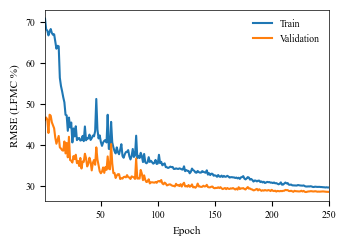

In [8]:
# -----------------------
# Train FINAL NN on TRAIN, evaluate on TEST each epoch
# -----------------------
yscaler = StandardScaler()
y_train_s = yscaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = yscaler.transform(y_test.reshape(-1,1)).ravel()

nn_final = build_model(n_num=n_num, n_species=num_species)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6),
    MetricsCallback(X_train_num_std, sp_train_ids, y_train,
                    X_test_num_std,  sp_test_ids,  y_test, yscaler, every=1)  # print every epoch
]


history = nn_final.fit(
    [X_train_num_std, sp_train_ids], y_train_s.astype(np.float32),
    validation_data=([X_test_num_std, sp_test_ids], y_test_s.astype(np.float32)),
    epochs=500, batch_size=256,
    callbacks=callbacks, verbose=1,
    sample_weight=sample_weight_train
)



# ---------- Convergence figure (RMSE vs. epoch) ----------
rmse_tr  = history.history["rmse_train"]
rmse_val = history.history["rmse_test"] 
epochs   = np.arange(1, len(rmse_tr) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, rmse_tr,  label="Train",      lw=1.5)
ax.plot(epochs, rmse_val, label="Validation", lw=1.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE (LFMC %)")
ax.set_xlim(1, len(epochs))
ax.legend(frameon=False, loc="best")

fig.tight_layout()
fig.savefig("lfmc_rmse_convergence.png", dpi=300)  # hi-res PNG for slides, etc.

print("[FIG] Convergence figure saved as lfmc_rmse_convergence.[pdf|png]")



# Final TEST metrics (redundant with last epoch print; kept for convenience)
yhat_test_s = nn_final.predict([X_test_num_std, sp_test_ids], verbose=0).ravel()
yhat_test = yscaler.inverse_transform(yhat_test_s.reshape(-1,1)).ravel()
m_test_nn = compute_metrics(y_test, yhat_test)
print(f"[NN FINAL TEST] RMSE={m_test_nn['rmse']:.3f}  R={m_test_nn['r']:.3f}  NSE={m_test_nn['nse']:.3f}  "
      f"RE={m_test_nn['relative_error']:.3f}  MAPE={m_test_nn['mape']:.3f}")

# report TRAIN metrics for context
yhat_train_s = nn_final.predict([X_train_num_std, sp_train_ids], verbose=0).ravel()
yhat_train = yscaler.inverse_transform(yhat_train_s.reshape(-1,1)).ravel()
m_train_nn = compute_metrics(y_train, yhat_train)
print(f"[NN FINAL TRAIN] RMSE={m_train_nn['rmse']:.3f}  R={m_train_nn['r']:.3f}  NSE={m_train_nn['nse']:.3f}")

271 unique locations in FULL data set


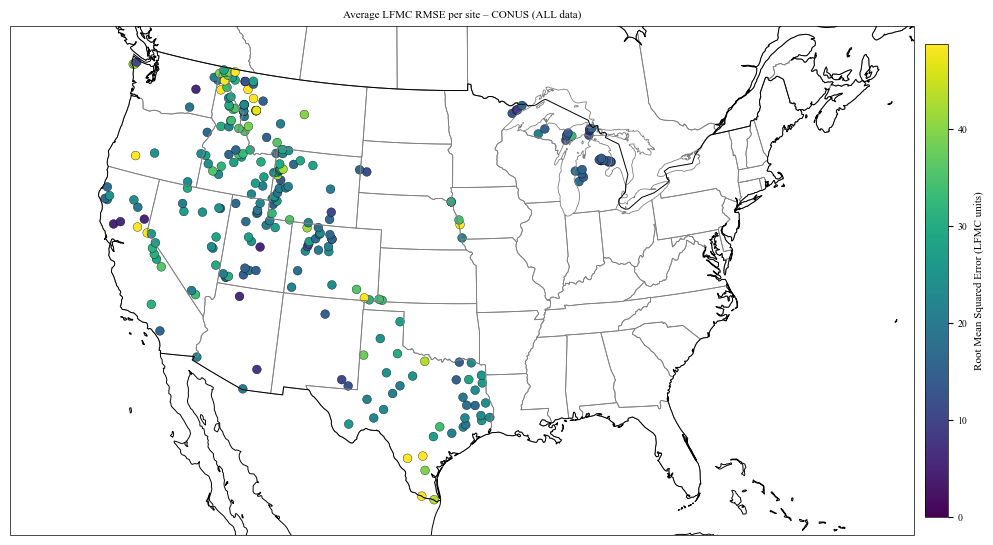

In [9]:
# ============================================================
# RMSE per site on the FULL data set (train + test)
# ============================================================

#  Predict LFMC for ALL rows
X_all_num_imputed = imp_final.transform(X_num_df[model_cols])
X_all_num_std     = scaler.transform(X_all_num_imputed)

yhat_all_s = nn_final.predict([X_all_num_std, sp_ids_all], verbose=0).ravel()
yhat_all   = yscaler.inverse_transform(yhat_all_s.reshape(-1, 1)).ravel()

all_df = df.copy()
all_df["y_true"]        = y_all
all_df["y_pred"]        = yhat_all
all_df["squared_error"] = (all_df["y_pred"] - all_df["y_true"])**2   # (ŷ – y)²

#Compute RMSE per unique point
point_rmse_all = (all_df
                  .groupby([LAT_COL, LON_COL], as_index=False)["squared_error"]
                  .mean()
                  .rename(columns={"squared_error": "mse"}))          # MSE per site
point_rmse_all["rmse"] = np.sqrt(point_rmse_all["mse"])              # √MSE → RMSE

print(f"{len(point_rmse_all):,} unique locations in FULL data set")
point_rmse_all.to_csv("point_rmse_ALL.csv", index=False)

# Keep only CONUS sites
conus_bounds = dict(lon_min=-125, lon_max=-66.5, lat_min=24, lat_max=50)
pm_conus = point_rmse_all[
    (point_rmse_all[LON_COL] >= conus_bounds["lon_min"]) &
    (point_rmse_all[LON_COL] <= conus_bounds["lon_max"]) &
    (point_rmse_all[LAT_COL] >= conus_bounds["lat_min"]) &
    (point_rmse_all[LAT_COL] <= conus_bounds["lat_max"])
].copy()

#Plot on a CONUS basemap
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAVE_CARTOPY = True
except ImportError:
    HAVE_CARTOPY = False
    print("Cartopy not found — install with `pip install cartopy` for the full map; "
          "falling back to a plain scatter.")

vmax = np.nanpercentile(pm_conus["rmse"], 95)  # clip outliers

if HAVE_CARTOPY:
    proj = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5)
    fig = plt.figure(figsize=(11, 7))
    ax = plt.axes(projection=proj)
    ax.set_extent([conus_bounds["lon_min"], conus_bounds["lon_max"],
                   conus_bounds["lat_min"],  conus_bounds["lat_max"]],
                  crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, edgecolor="gray")
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.7)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.7)

    sc = ax.scatter(pm_conus[LON_COL], pm_conus[LAT_COL],
                    c=pm_conus["rmse"], cmap="viridis",
                    s=40, vmin=0, vmax=vmax,
                    transform=ccrs.PlateCarree(),
                    edgecolor="k", linewidth=0.25)

    cbar = plt.colorbar(sc, ax=ax, pad=0.01, shrink=0.7,
                        label="Root Mean Squared Error (LFMC units)")
    ax.set_title("Average LFMC RMSE per site – CONUS (ALL data)")
    plt.tight_layout()
else:
    plt.figure(figsize=(11, 6))
    sc = plt.scatter(pm_conus[LON_COL], pm_conus[LAT_COL],
                     c=pm_conus["rmse"], cmap="viridis",
                     s=60, vmin=0, vmax=vmax,
                     edgecolor="k", linewidth=0.3)
    plt.colorbar(sc, label="Root Mean Squared Error (LFMC units)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Average LFMC RMSE per site – CONUS (ALL data)")
    plt.tight_layout()

#plt.savefig('rmse_map.tif', bbox_inches="tight")


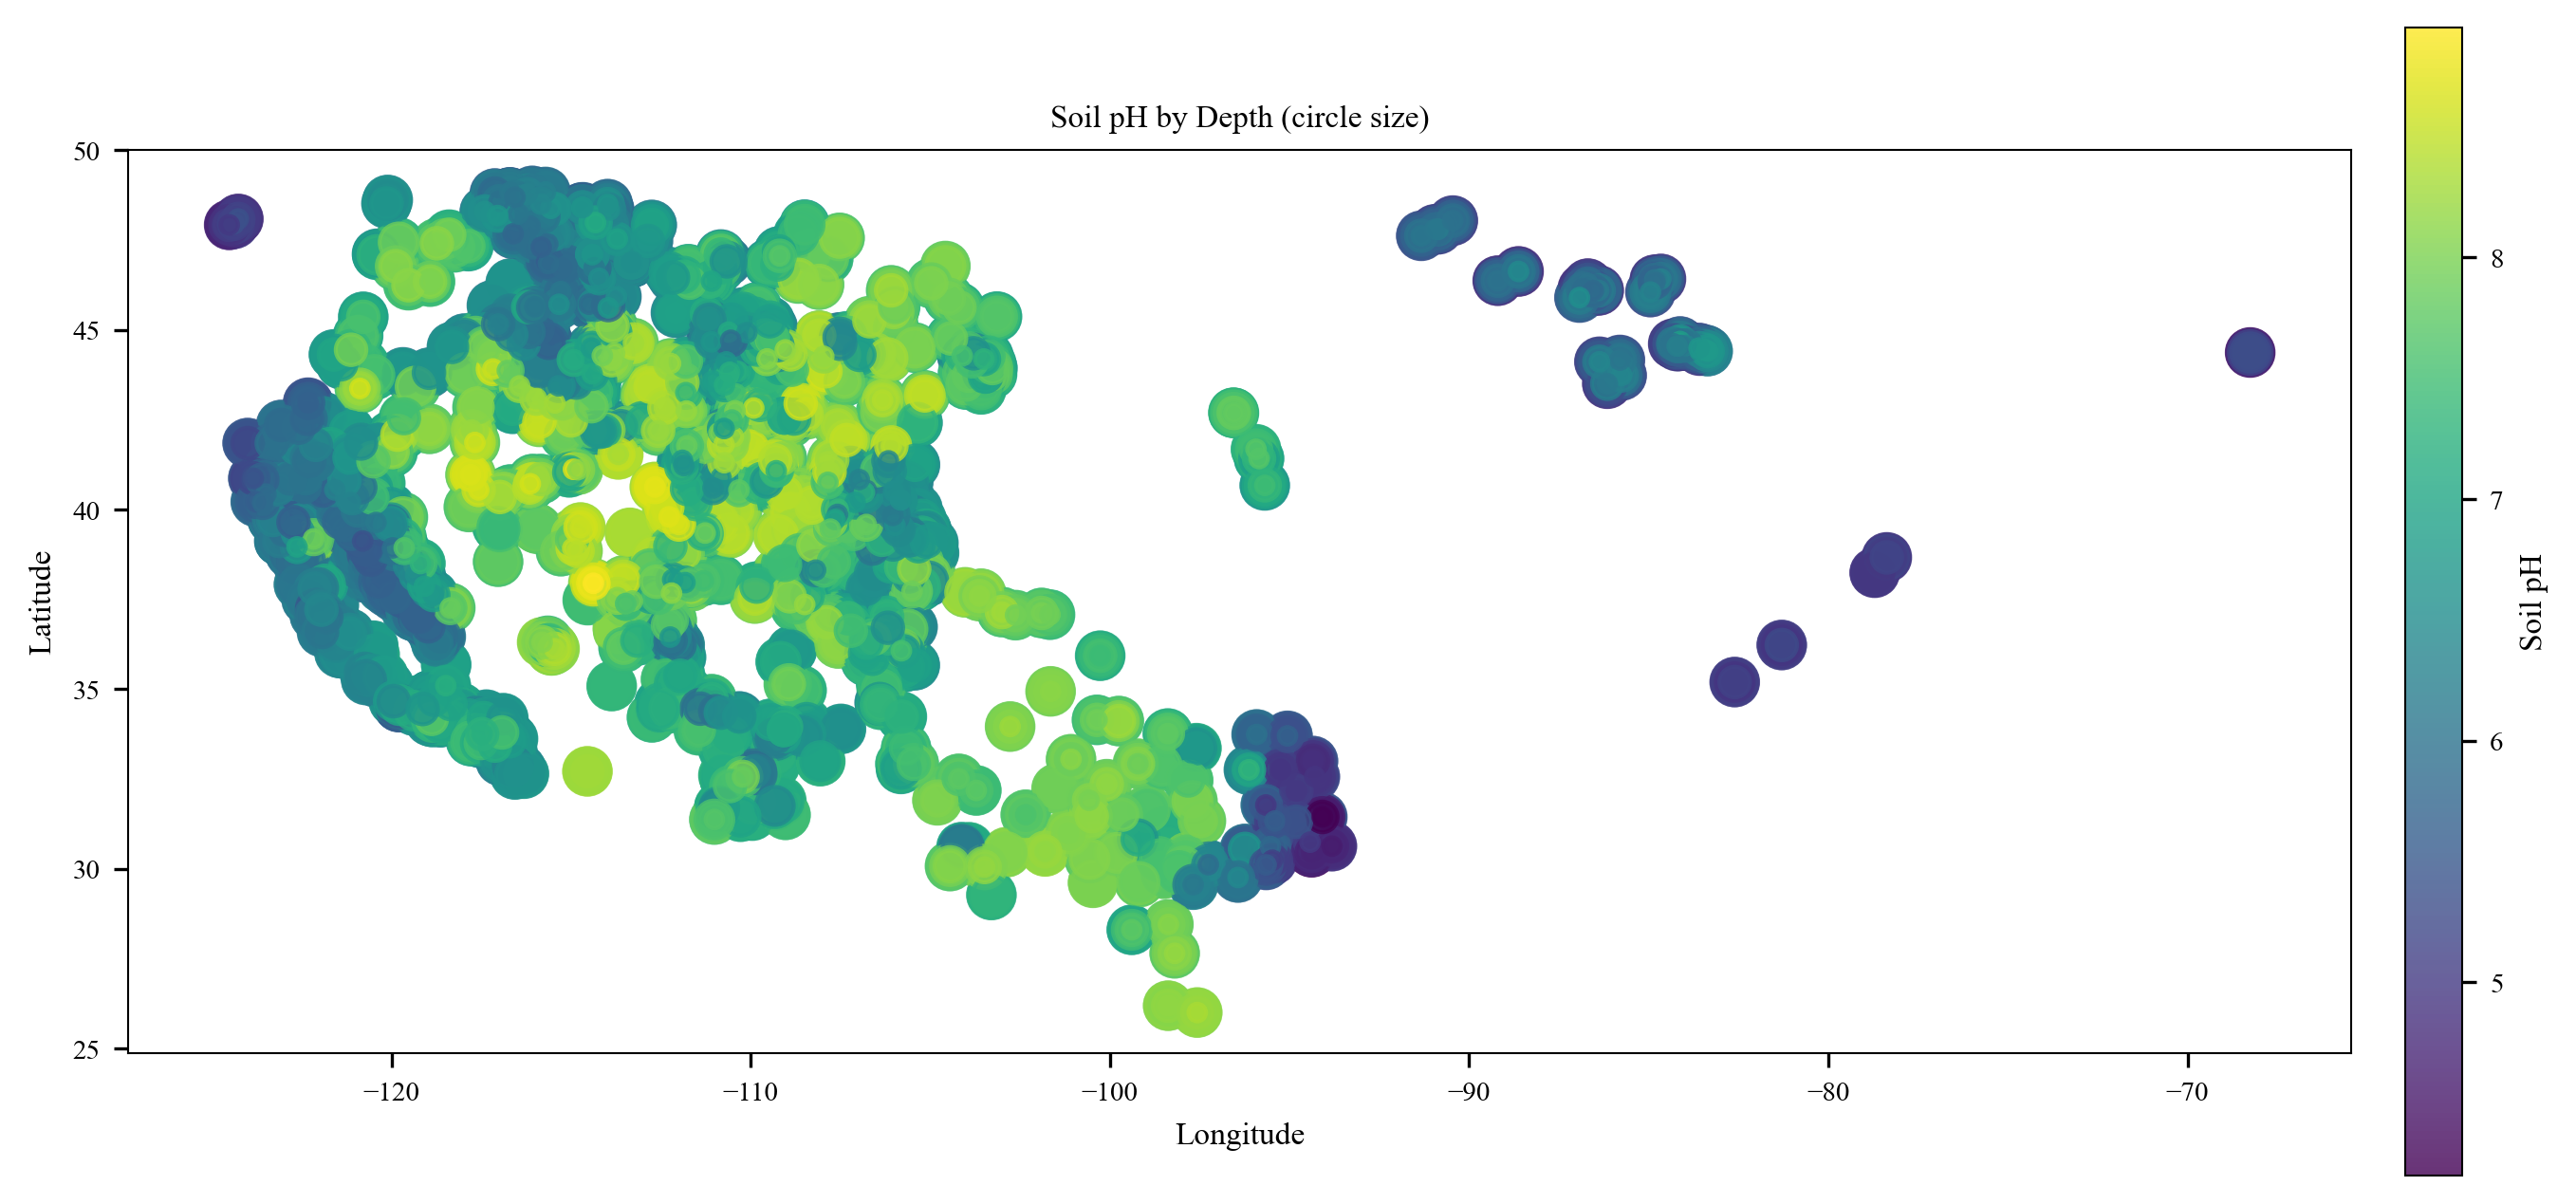

In [10]:
#  READ & RESHAPE to plot PH at different depth
df = pd.read_csv("data/only_ph.csv")
ph_cols = [c for c in df.columns if c.startswith("pH_pH_r_")]

depth_cm = lambda col: int(col.split("_")[3])

long_df = (
    df.melt(id_vars=["lat", "lon"],
            value_vars=ph_cols,
            var_name="depth_col",
            value_name="pH_raw")
      .assign(depth_cm=lambda d: d["depth_col"].apply(depth_cm),
              pH=lambda d: d["pH_raw"] / 100)
      .drop(columns=["depth_col", "pH_raw"])
)

# ── 2. FILTER BAD VALUES ─────────────────────────────────────
long_df = long_df[long_df["pH"] >= -10]

# ── 3. SIZE MAPPING (depth 0 = largest) ──────────────────────
max_depth = long_df["depth_cm"].max()
min_size, max_size = 20, 140          # tweak as you like
long_df["size"] = (1 - long_df["depth_cm"]/max_depth) * (max_size - min_size) + min_size
long_df = long_df.sort_values("size", ascending=False)

# ── 4. 2-D SCATTER PLOT ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

sc = ax.scatter(
    long_df["lon"],
    long_df["lat"],
    s=long_df["size"],
    c=long_df["pH"],          # colour = actual pH
    alpha=0.8
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Soil pH by Depth (circle size)")
ax.set_aspect('equal', adjustable='box')

# colour-bar in real-world pH
cbar = fig.colorbar(sc, pad=0.02, shrink=0.7)
cbar.set_label("Soil pH")

plt.tight_layout()
plt.show()


In [11]:
# ============================================================
# RMSE per site on the FULL data set (train + test)
# ============================================================

# -------- 1) Predict LFMC for ALL rows -----------------------
# Re-use the *fitted* transformers from earlier cells
X_all_num_imputed = imp_final.transform(X_num_df[model_cols])
X_all_num_std     = scaler.transform(X_all_num_imputed)

yhat_all_s = nn_final.predict([X_all_num_std, sp_ids_all], verbose=0).ravel()
yhat_all   = yscaler.inverse_transform(yhat_all_s.reshape(-1, 1)).ravel()

# -------- 2) Build DataFrame with true, pred, squared error --
all_df = df.copy()
all_df["y_true"]        = y_all
all_df["y_pred"]        = yhat_all
all_df["squared_error"] = (all_df["y_pred"] - all_df["y_true"])**2   # (ŷ – y)²

# -------- 3) Compute RMSE per unique point -------------------
point_rmse_all = (all_df
                  .groupby([LAT_COL, LON_COL], as_index=False)["squared_error"]
                  .mean()
                  .rename(columns={"squared_error": "mse"}))          # MSE per site
point_rmse_all["rmse"] = np.sqrt(point_rmse_all["mse"])              # √MSE → RMSE

print(f"{len(point_rmse_all):,} unique locations in FULL data set")
point_rmse_all.to_csv("point_rmse_ALL.csv", index=False)

# -------- 4) Keep only CONUS sites ---------------------------
conus_bounds = dict(lon_min=-125, lon_max=-66.5, lat_min=24, lat_max=50)
pm_conus = point_rmse_all[
    (point_rmse_all[LON_COL] >= conus_bounds["lon_min"]) &
    (point_rmse_all[LON_COL] <= conus_bounds["lon_max"]) &
    (point_rmse_all[LAT_COL] >= conus_bounds["lat_min"]) &
    (point_rmse_all[LAT_COL] <= conus_bounds["lat_max"])
].copy()

# -------- 5) Plot on a CONUS basemap -------------------------
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAVE_CARTOPY = True
except ImportError:
    HAVE_CARTOPY = False
    print("Cartopy not found — install with `pip install cartopy` for the full map; "
          "falling back to a plain scatter.")

vmax = np.nanpercentile(pm_conus["rmse"], 95)  # clip outliers

if HAVE_CARTOPY:
    proj = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5)
    fig = plt.figure(figsize=(11, 7))
    ax = plt.axes(projection=proj)
    ax.set_extent([conus_bounds["lon_min"], conus_bounds["lon_max"],
                   conus_bounds["lat_min"],  conus_bounds["lat_max"]],
                  crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, edgecolor="gray")
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.7)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.7)

    sc = ax.scatter(pm_conus[LON_COL], pm_conus[LAT_COL],
                    c=pm_conus["rmse"], cmap="viridis",
                    s=40, vmin=0, vmax=vmax,
                    transform=ccrs.PlateCarree(),
                    edgecolor="k", linewidth=0.25)

    cbar = plt.colorbar(sc, ax=ax, pad=0.01, shrink=0.7,
                        label="Root Mean Squared Error (LFMC units)")
    ax.set_title("Average LFMC RMSE per site – CONUS (ALL data)")
    plt.tight_layout()
else:
    plt.figure(figsize=(11, 6))
    sc = plt.scatter(pm_conus[LON_COL], pm_conus[LAT_COL],
                     c=pm_conus["rmse"], cmap="viridis",
                     s=60, vmin=0, vmax=vmax,
                     edgecolor="k", linewidth=0.3)
    plt.colorbar(sc, label="Root Mean Squared Error (LFMC units)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Average LFMC RMSE per site – CONUS (ALL data)")
    plt.tight_layout()

plt.savefig('rmse_map.tif', bbox_inches="tight")


ValueError: Length of values (25238) does not match length of index (1031)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── 1. READ & RESHAPE ─────────────────────────────────────────
df = pd.read_csv("only_ph.csv")
ph_cols = [c for c in df.columns if c.startswith("pH_pH_r_")]

depth_cm = lambda col: int(col.split("_")[3])

long_df = (
    df.melt(id_vars=["lat", "lon"],
            value_vars=ph_cols,
            var_name="depth_col",
            value_name="pH_raw")
      .assign(depth_cm=lambda d: d["depth_col"].apply(depth_cm),
              pH=lambda d: d["pH_raw"] / 100)
      .drop(columns=["depth_col", "pH_raw"])
)

# ── 2. FILTER BAD VALUES ─────────────────────────────────────
long_df = long_df[long_df["pH"] >= -10]

# ── 3. SIZE MAPPING (depth 0 = largest) ──────────────────────
max_depth = long_df["depth_cm"].max()
min_size, max_size = 20, 140          # tweak as you like
long_df["size"] = (1 - long_df["depth_cm"]/max_depth) * (max_size - min_size) + min_size
long_df = long_df.sort_values("size", ascending=False)

# ── 4. 2-D SCATTER PLOT ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

sc = ax.scatter(
    long_df["lon"],
    long_df["lat"],
    s=long_df["size"],
    c=long_df["pH"],          # colour = actual pH
    alpha=0.8
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Soil pH by Depth (circle size)")
ax.set_aspect('equal', adjustable='box')

# colour-bar in real-world pH
cbar = fig.colorbar(sc, pad=0.02, shrink=0.7)
cbar.set_label("Soil pH")

plt.tight_layout()
plt.show()
